In [1]:
import pandas as pd
from xgboost import XGBClassifier, cv
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from bayes_opt import BayesianOptimization
import numpy as np

SEED=0

# Load the dataset
- Load data from excel sheet
- Set X (independent variables) and y (dependent variables) 

In [2]:
data_path = './data/master_4Mayhew.xlsx'
df = pd.read_excel(data_path)
df.set_index('SMILES', inplace=True)
y=df['label'] # labels, independent variables
X=df.drop(['label'], axis=1) # features, dependent variables

df

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,label
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,10.191572,9.610016,0,0,16.402096,2.535251,4.795559,16.402096,1.261700,3.521954,...,60.186518,178.026609,9.369822,209,23,72,89,5.506944,2.750000,False
C(=C(F)F)(C(F)(F)F)C(F)(F)F,8.786807,9.354315,0,0,11.264384,2.394170,4.788340,11.264384,0.938699,3.353751,...,43.053817,199.987226,16.665602,179,16,58,63,8.347222,2.444444,False
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],11.877237,11.411786,0,0,18.380381,2.411142,4.822284,18.380381,1.148774,3.664511,...,48.280750,228.997099,12.052479,408,25,78,90,8.277778,3.555556,False
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,15.682318,12.964430,0,0,26.034025,2.456696,4.859289,26.034025,1.301701,3.935426,...,61.882766,284.071641,8.608232,726,36,106,126,6.277778,4.388889,False
C(C(C(F)(F)F)(F)Cl)(F)Cl,7.220990,7.794227,0,0,9.758256,2.380983,4.761966,9.758256,0.975826,3.172059,...,40.351995,201.937546,18.357959,108,15,48,54,7.236111,2.062500,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,5.766244,6.059284,0,0,10.383983,2.015316,4.030632,10.383983,1.153776,3.007982,...,35.041491,130.099380,5.656495,108,7,32,31,4.361111,2.416667,True
C=CCSS(=O)CC=C,5.766244,6.059284,0,0,10.383983,2.015316,4.030632,10.383983,1.153776,3.007982,...,35.041491,162.017307,8.527227,108,7,32,31,4.361111,2.416667,True
CCCC(=O)OCC(C)C,6.692130,6.855805,0,0,11.127090,2.052881,4.105762,11.127090,1.112709,3.123647,...,37.120200,144.115030,5.542886,143,8,38,37,5.222222,2.500000,True


# Explore the dataset

## How many missing values?

- There's 92 columns all NaNs
- 160 columns with > 90% NaNs

In [3]:
print(df.isna().mean(axis=0).nlargest(300))

SpAbs_Dt     1.000000
SpMax_Dt     1.000000
SpDiam_Dt    1.000000
SpAD_Dt      1.000000
SpMAD_Dt     1.000000
               ...   
AATS6m       0.213873
AATS6v       0.213873
AATS6se      0.213873
AATS6pe      0.213873
AATS6are     0.213873
Length: 300, dtype: float64


In [4]:
print(f"Number of columns with all NaNs \n{(df.isna().mean(axis=0) == 1).value_counts()}")

Number of columns with all NaNs 
False    1735
True       92
dtype: int64


In [5]:
print(f"Number of columns with >0.9 NaNs \n{(df.isna().mean(axis=0) > 0.9).value_counts()}")

Number of columns with >0.9 NaNs 
False    1667
True      160
dtype: int64


In [6]:
print(f"Number of columns with a NaN \n{ len(df.columns[df.isna().any()].tolist())}")

Number of columns with a NaN 
623


### Visualise number of NaNs in descriptors with missing values 

Text(0.5, 0, 'Percentage NaNs in descriptors with missing values')

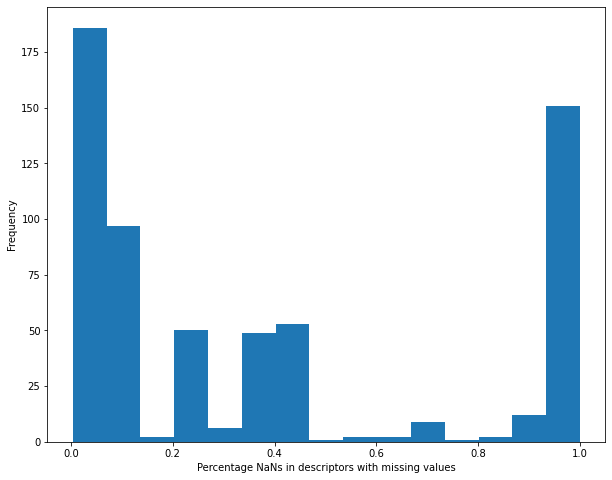

In [8]:
percs = df.isna().mean(axis=0)

ax = percs[(percs > 0)].plot.hist(figsize=(10, 8), bins=15)
plt.xlabel("Percentage NaNs in descriptors with missing values")

## Correlation between the descriptors

- degree to which features are related 
- https://jayant017.medium.com/hyperparameter-tuning-in-xgboost-using-randomizedsearchcv-88fcb5b58a73

In [4]:
# Remove descriptors of dataframe with > 50% nans
nans = df.isna().mean(axis=0)
# set threshold for percentage nans before we drop 
thresh = nans[nans >= 0.5]
df_corrs = df.copy()
df_corrs = df_corrs.drop(thresh.index, axis=1)
corrs = df_corrs.corr()
corrs

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,label
ABC,1.000000,0.984817,0.002461,0.030907,0.989272,0.728026,0.735420,0.989272,0.528869,0.920121,...,0.882940,0.938751,-0.164554,0.853747,0.958762,0.991934,0.975321,0.784337,0.952894,-0.403256
ABCGG,0.984817,1.000000,0.017644,0.022007,0.966578,0.775729,0.781912,0.966578,0.529618,0.945448,...,0.903297,0.932150,-0.185056,0.798247,0.943907,0.974350,0.955708,0.841003,0.943962,-0.397517
nAcid,0.002461,0.017644,1.000000,0.220033,-0.026060,0.013846,0.020202,-0.026060,-0.108716,0.010658,...,-0.015430,0.016209,0.020762,-0.000492,-0.026008,-0.008421,-0.021712,0.119666,-0.010251,-0.219711
nBase,0.030907,0.022007,0.220033,1.000000,0.029622,-0.004723,-0.003677,0.029622,0.019905,-0.001987,...,0.009335,0.020061,-0.052047,0.087532,0.024540,0.032639,0.033790,0.011183,0.022760,-0.129745
SpAbs_A,0.989272,0.966578,-0.026060,0.029622,1.000000,0.686444,0.694428,1.000000,0.585872,0.911180,...,0.860329,0.925137,-0.191532,0.862143,0.940489,0.973580,0.954450,0.727824,0.974252,-0.369529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zagreb1,0.991934,0.974350,-0.008421,0.032639,0.973580,0.733251,0.736072,0.973580,0.509538,0.892694,...,0.888302,0.923774,-0.131867,0.836143,0.978751,1.000000,0.995078,0.768777,0.915895,-0.429542
Zagreb2,0.975321,0.955708,-0.021712,0.033790,0.954450,0.727515,0.726369,0.954450,0.500624,0.863221,...,0.884178,0.899164,-0.116056,0.813741,0.985556,0.995078,1.000000,0.740262,0.881352,-0.438329
mZagreb1,0.784337,0.841003,0.119666,0.011183,0.727824,0.614418,0.646097,0.727824,0.088493,0.745377,...,0.645128,0.825265,-0.058776,0.685694,0.779434,0.768777,0.740262,1.000000,0.773834,-0.429089
mZagreb2,0.952894,0.943962,-0.010251,0.022760,0.974252,0.625249,0.641950,0.974252,0.562932,0.897124,...,0.794815,0.920330,-0.214293,0.861128,0.883217,0.915895,0.881352,0.773834,1.000000,-0.328786


In [11]:
corrs.to_csv('descriptor-correlations.csv')  

# Extract correlation scores for important features

In [4]:
def corrs_important_features(model, X_test, model_name, nlargest=100, heatmap=14):
    feature_imp = pd.Series(model.feature_importances_,index=X_test.columns.values).sort_values(ascending=False)
    top_100 = feature_imp.nlargest(100)
    important_df = df.loc[:,top_100.index]
    corrs = important_df.corr()
    
    print(f"Extracted correlation scores for most important {nlargest} features for {model_name}")
    corrs.to_csv(f'correlations/descriptor-corrs-top{nlargest}-{model_name}.csv')  
    
    # Print heatmap for top n
    print(f"Printing heatmap for most important {heatmap} features")
    
    top_10 = feature_imp.nlargest(heatmap)
    important_df_10 = df.loc[:,top_10.index]
    corrs_10 = important_df_10.corr()
    
    plt.figure(figsize = (16,16))
    heatmap = sns.heatmap(corrs_10, vmin=-1, vmax=1, annot=True)
    # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Split the dataset
- Split dataset into training and test set 
- Use equal proportions of odor/odorless class

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0) # 70% training and 30% test

print(f"Total number molecules in training set: {y_train.shape[0]}")
print(f"Odor: {y_train.value_counts()[True]}")
print(f"Odorless: {y_train.value_counts()[False]}")

print(f"\nTotal number molecules in test set: {y_test.shape[0]}")
print(f"Odor: {y_test.value_counts()[True]}")
print(f"Odorless: {y_test.value_counts()[False]}")

print(f"\nPercentage odorless {y_test.value_counts()[False]/y_test.shape[0]}")

Total number molecules in training set: 692
Odor: 492
Odorless: 200

Total number molecules in test set: 173
Odor: 123
Odorless: 50

Percentage odorless 0.28901734104046245


# Test Model 

In [6]:
def test_model(model, y_test, X_test, verbose=True):
    y_pred=model.predict(X_test)
    y_pred_probs=model.predict_proba(X_test)[:,1]
    
    if verbose:
        print("ROC_AUC (TEST):",metrics.roc_auc_score(y_test, y_pred_probs))
        print("\n\nCLASSIFICATION REPORT:\n",metrics.classification_report(y_test, y_pred))
        
        feature_imp = pd.Series(model.feature_importances_,index=X_test.columns.values).sort_values(ascending=False)
        top_20 = feature_imp.nlargest(20)
        sns.barplot(x=top_20, y=top_20.index)
        plt.xlabel('Descriptor Importance Score')
        plt.ylabel('Descriptor')
        plt.title("Top 20 descriptors")
        plt.show()
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probs)  
        
        #create ROC curve
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    return metrics.roc_auc_score(y_test, y_pred_probs) 

# Handle Non Important Descriptors 

1. Remove values below threshold e.g. 0, any descriptors with 0 importance
2. Get the top N descriptors

In [7]:
def handle_importance(model, X_train, X_test, threshold=-1, n=-1, verbose=None):
    feature_imp = pd.Series(model.feature_importances_,index=X_train.columns.values).sort_values(ascending=False)
    if threshold >= 0:
        feature_imp = feature_imp[feature_imp > threshold]
    
    if n >= 0: 
        feature_imp = feature_imp.nlargest(n)
        
    if verbose: 
        print(feature_imp)
        
    X_train = X_train.loc[:, feature_imp.axes[0].tolist()]
    X_test = X_test.loc[:, feature_imp.axes[0].tolist()]

    return X_train, X_test, model 

In [41]:
imp_params = [{"threshold":0, 'n':-1},
              {"threshold":0.001, 'n':-1},
              {"threshold":0.01, 'n':-1},
              {"threshold":-1, 'n':100}, 
              {"threshold":-1, 'n':500}, 
              {"threshold":-1, 'n':1000},
              {"threshold":-1, 'n':1203}]

# These descriptors must be included in every experiment 
check_descriptors = ['TopoPSA(NO)', 'nHetero', 'nHBDon', 'ATS4P', 'NsCH3', 'IC3', 'EState_VSA6', 'AATSOV', 'NsOH','SpAD_DzZ', 'SM1_DZ(v)']

def optimiseImportance(model, X_train, X_test, y_train, y_test, k=5, verbose=True):
    print(f"Cross validated importance experiment with k={k}")
    
    imp_df = pd.DataFrame(columns=['Name', 'Average ROC_AUC', 'Standard Deviation'])

    for imp_param in imp_params: 
        name = (f"Threshold:{imp_param['threshold']}N:{imp_param['n']}".replace("N:-1", '')).replace("Threshold:-1", '')
        print(name)

        X_train_cv, _, _ = handle_importance(model, 
                                            X_train.copy(), 
                                            X_test.copy(), 
                                            threshold=imp_param['threshold'], 
                                            n=imp_param['n'])
        

#         if not set(check_descriptors).issubset(set(X_train_fold.columns.values.tolist())): 
#             continue
#         else:
        roc_auc_nans = cross_val_score(model, X_train_cv, y_train, cv=k, scoring='roc_auc')
        
        imp_df = imp_df.append({'Name': name, 
                               'Average ROC_AUC':np.mean(roc_auc_nans), 
                               'Standard Deviation':np.std(roc_auc_nans)}, 
                                ignore_index = True)

    if verbose:
        fig = imp_df.plot(kind="bar", x="Name", y="Average ROC_AUC", yerr="Standard Deviation", title=f"ROC_AUC after filtering descriptors by importance CV={k}", legend=False)
        plt.ylim(0.95,0.98)
        
    return imp_df

# Handle NaNs


- You cannot have any missing values in the random forest model, you can in XGB
- You cannot have mismatched features between columns in the random forest model
- 3 options 
    1. Remove any columns with missing values 
    2. Remove columns above threshold percentange NaNs e.g. 60% NaNs. 
    3. Remove columns above threshold percentange NaNs e.g. 60% NaNs. Replace columns below threshold with missing values with the mean value.

In [8]:
def handleNaNs(X_tr, X_te, option=1, thresh=0.6): 
    if option == 1:
        nans =  X.columns[X.isna().any()].tolist()
        X_tr.drop(nans, inplace = True, axis=1)
        X_te.drop(nans, inplace = True, axis=1)
    else: 
        nans = X.isna().mean(axis=0)
        # set threshold for percentage nans before we drop 
        X_thresh = nans[nans >= thresh]
        X_tr.drop(X_thresh.index, 
          axis=1, 
          inplace=True)
        X_te.drop(X_thresh.index, 
          axis=1, 
          inplace=True)
        
        if option == 3: 
            X_tr.fillna(X_train.mean(), inplace=True) 
            X_te.fillna(X_test.mean(), inplace=True)
    
    return X_tr, X_te

In [12]:
def optimiseNaNs(model, X_train, X_test, y_train, y_test, option=2, k=5, verbose=True): 
    print(f"Cross validated missing values experiment with k={k}")
    
    percentages = [x/100 for x in range(0, 100, 10)] 
    nans_df = pd.DataFrame(columns=['Name', 'Average ROC_AUC', 'Standard Deviation'])

    for perc in percentages: 
        name = str(perc)
        if perc == 0:
            X_train_cv, _  = handleNaNs(X_train.copy(), X_test.copy(), option=1)
        else:
            X_train_cv, _  = handleNaNs(X_train.copy(), X_test.copy(), option=option, thresh=perc)

        roc_auc_nans = cross_val_score(model, X_train_cv, y_train, cv=k, scoring='roc_auc')
        
        nans_df = nans_df.append({'Name': name, 
                                   'Average ROC_AUC':np.mean(roc_auc_nans), 
                                   'Standard Deviation':np.std(roc_auc_nans)}, 
                                    ignore_index = True)

    if verbose:
        fig = nans_df.plot(kind="bar", x="Name", y="Average ROC_AUC", yerr="Standard Deviation", title=f"ROC_AUC after thresholding descriptors by % NaNs CV={k}", legend=False)
        plt.ylim(0.95,0.98)
        
    return nans_df

# Random Forest Model

https://www.datacamp.com/tutorial/random-forests-classifier-python

In [33]:
# set random state to 0 to allow reproducible results
clf=RandomForestClassifier(random_state=0) 

# For readability
y_train_rf = y_train
y_test_rf = y_test
X_train_rf = X_train
X_test_rf = X_test

## Handle NaNs RF

Cross validated missing values experiment with k=5


,Name,Average ROC_AUC,Standard Deviation
0,0.0,0.970784,0.003906
1,0.1,0.968146,0.002932
2,0.2,0.968500,0.005369
3,0.3,0.967892,0.003344
4,0.4,0.967466,0.004047
5,0.5,0.964738,0.006947
6,0.6,0.967132,0.002913
7,0.7,0.967452,0.004857
8,0.8,0.968936,0.004855
9,0.9,0.963971,0.004127


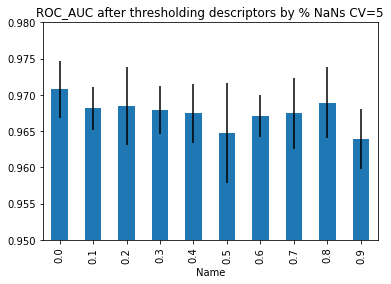

In [34]:
# choose optimal threshold for removing columns with NaNs
optimiseNaNs(clf, X_train_rf, X_test_rf, y_train_rf, y_test_rf, option=3)

It seems to have a very high standard deviation, so let's just go with removing all the columns with missing values

In [35]:
X_train_rf, X_test_rf = handleNaNs(X_train.copy(), X_test.copy(), option=1)

In [36]:
X_train_rf

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],8.841960,8.193289,1,0,14.383377,2.278414,4.556827,14.383377,1.198615,3.375782,...,0.000000,9.076237,42.233090,167.021858,9.824815,206,15,56,62,2.722222
CCCCCCCCCCCCCCCCO,11.313709,9.412260,0,0,20.860105,1.969616,3.939231,20.860105,1.227065,3.644675,...,0.000000,8.164226,45.799808,242.260966,4.750215,816,14,62,60,4.500000
C1(C(O1)(F)F)(C(F)(F)F)F,7.835111,8.587182,0,0,10.249622,2.654002,4.922702,10.249622,1.024962,3.316427,...,8.504918,9.973060,63.138207,165.985334,16.598533,105,13,58,72,1.875000
CC(C)(C=C)O,4.012290,4.284816,0,0,5.818626,2.074313,4.148627,5.818626,0.969771,2.626363,...,0.000000,7.989899,31.665095,86.073165,5.379573,28,3,24,22,1.375000
C=CCC1=CC2=C(C=C1)OCO2,9.151948,8.339656,0,0,15.669060,2.362602,4.630996,15.669060,1.305755,3.422391,...,6.580639,9.203014,56.229240,162.068080,7.366731,197,14,60,69,2.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCS,2.828427,3.146264,0,0,5.464102,1.732051,3.464102,5.464102,1.092820,2.390167,...,0.000000,6.192362,25.583106,90.050321,6.003355,20,2,14,12,1.500000
CCN(CC)CC,4.242641,4.859933,0,1,8.000000,2.000000,4.000000,8.000000,1.142857,2.753451,...,0.000000,7.627057,31.941317,101.120450,4.596384,48,6,24,24,2.000000
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,10.635111,9.197041,0,0,18.814625,2.307250,4.614501,18.814625,1.343902,3.558646,...,0.000000,9.282754,45.217583,182.073165,7.586382,307,18,68,77,3.222222


Test performance of Random Forest after removing all columns with NaNs
ROC_AUC (TEST): 0.9741463414634146


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.88      0.86      0.87        50
        True       0.94      0.95      0.95       123

    accuracy                           0.92       173
   macro avg       0.91      0.91      0.91       173
weighted avg       0.92      0.92      0.92       173



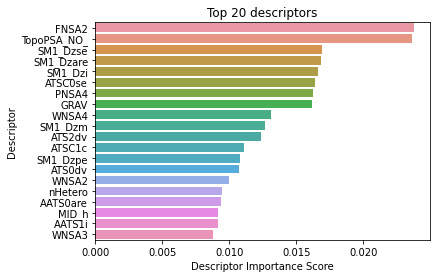

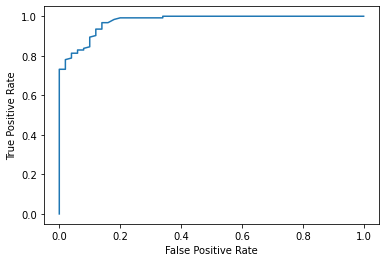

0.9741463414634146

In [37]:
clf.fit(X_train_rf, y_train_rf)
print("Test performance of Random Forest after removing all columns with NaNs")
test_model(clf, y_test_rf, X_test_rf)

## Importance Experiment

Cross validated importance experiment with k=5
Threshold:0
Threshold:0.001
Threshold:0.01
N:100
N:500
N:1000
N:1203


,Name,Average ROC_AUC,Standard Deviation
0,Threshold:0,0.970732,0.003541
1,Threshold:0.001,0.973341,0.004869
2,Threshold:0.01,0.960796,0.002965
3,N:100,0.973380,0.004403
4,N:500,0.972813,0.005964
5,N:1000,0.967023,0.003935
6,N:1203,0.971248,0.007054


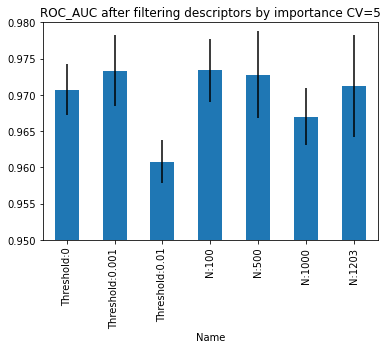

In [42]:
optimiseImportance(clf, X_train_rf, X_test_rf, y_train_rf, y_test_rf)

### Remove labels 
- best performance is with setting N to 100

In [43]:
X_train_rf, X_test_rf, clf = handle_importance(clf, 
                                               X_train_rf, 
                                               X_test_rf, 
                                               threshold=-1, 
                                               n=100)

Test performance of Random Forest after removing labels
ROC_AUC (TEST): 0.9778048780487806


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.92      0.88      0.90        50
        True       0.95      0.97      0.96       123

    accuracy                           0.94       173
   macro avg       0.93      0.92      0.93       173
weighted avg       0.94      0.94      0.94       173



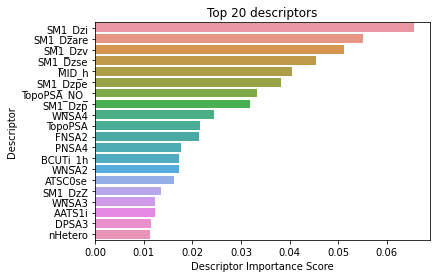

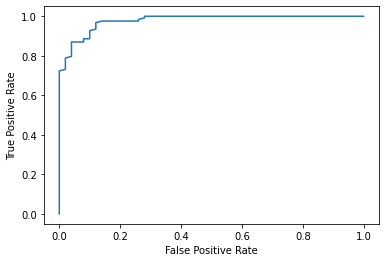

0.9778048780487806

In [44]:
clf.fit(X_train_rf, y_train_rf)
print("Test performance of Random Forest after removing labels")
test_model(clf, y_test_rf, X_test_rf)

In [45]:
X_train_rf

,FNSA2,TopoPSA_NO_,SM1_Dzse,SM1_Dzare,SM1_Dzi,ATSC0se,PNSA4,GRAV,WNSA4,SM1_Dzm,...,Mor09se,IC0,ATSC1dv,AATS0i,SMR,VSA_EState3,Mor31,Xpc_5dv,piPC2,AATSC1pe
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],-0.767715,80.44,1.134242,1.328525,0.917786,2.972664,-14.619011,2042.071181,-4.732438,1.139562,...,-0.093453,1.777985,7.411765,162.658468,40.0557,18.584666,-0.022071,0.365897,3.417727,0.018100
CCCCCCCCCCCCCCCCO,-0.164160,20.23,0.248495,0.285714,0.173134,1.263522,-2.006400,1704.627767,-1.250653,0.249266,...,0.318470,1.025881,-1.674740,166.693356,77.3978,8.643400,2.353381,0.000000,2.772589,-0.003319
C1(C(O1)(F)F)(C(F)(F)F)F,-1.270169,12.53,2.129495,2.627178,2.295353,3.149698,-33.188443,2387.169619,-8.671861,2.455999,...,-1.236477,1.295462,-4.000000,238.715811,15.9260,0.000000,0.012424,0.370199,2.995732,-0.084283
CC(C)(C=C)O,-0.209484,20.23,0.248495,0.285714,0.173134,1.036660,-3.397234,595.110492,-0.881495,0.249266,...,0.710519,1.198192,12.000000,166.787474,26.4948,8.708333,0.414549,0.091287,2.197225,-0.012862
C=CCC1=CC2=C(C=C1)OCO2,-0.491671,18.46,0.496990,0.571429,0.346268,1.882625,-7.888307,1869.582493,-2.784297,0.498531,...,-0.847671,1.348588,23.553719,158.546484,46.4660,0.000000,0.233277,0.592117,3.384390,0.006316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCS,-0.112203,0.00,0.071356,-0.024590,-0.086900,0.163932,-2.026929,441.365151,-0.549242,0.625359,...,0.576868,1.158939,-0.000219,164.245584,28.7610,0.000000,0.586830,0.000000,1.386294,-0.004077
CCN(CC)CC,-0.084435,3.24,0.140263,0.185668,0.225250,0.398851,-1.147137,688.729833,-0.342869,0.142500,...,0.984245,1.090653,12.049587,170.262317,33.4620,0.000000,0.603834,0.474342,1.945910,0.007868
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,-0.401193,17.07,0.248495,0.285714,0.173134,1.044981,-6.234910,2168.780768,-2.325509,0.249266,...,-0.088960,1.196421,12.000000,153.456435,56.3165,0.000000,0.406501,0.573767,3.663562,0.000473


## Tuning the hyperparamaters 

In [46]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(clf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


Fitting 5 folds for each of 500 candidates, totalling 2500 fits
{'n_estimators': 294, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 12, 'criterion': 'gini', 'bootstrap': False}
Hyperparamater tuned test performance of Random Forest
ROC_AUC (TEST): 0.9834146341463414


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.91      0.86      0.89        50
        True       0.94      0.97      0.96       123

    accuracy                           0.94       173
   macro avg       0.93      0.91      0.92       173
weighted avg       0.94      0.94      0.94       173



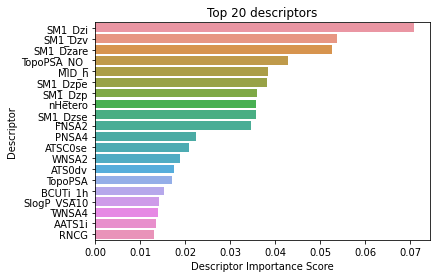

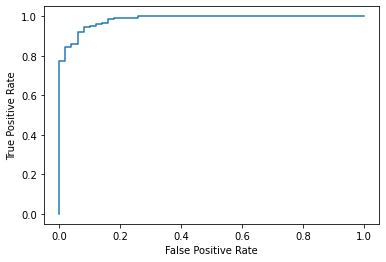

0.9834146341463414

In [49]:
# Use the grid to search for best hyperparameters
# Takes ~ 5 minutes to run 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 50)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 20, num = 50)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 40, 60, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion 
criterion = ['gini', 'entropy']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap, 
               'criterion': criterion}

# Random search of parameters, using 5 fold cross validation, 
# search across 500 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=clf, param_distributions = random_grid, n_iter = 500, cv = 5, verbose=1, random_state=SEED, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_rf, y_train_rf)

# Print best paramaters 
print(rf_random.best_params_)

print("Hyperparamater tuned test performance of Random Forest")
test_model(rf_random.best_estimator_, y_test_rf, X_test_rf)

In [50]:
rf_random.best_estimator_.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 294,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [53]:
tuned_rf= RandomForestClassifier(n_estimators=294,
                                 min_samples_split=10,
                                 min_samples_leaf=1,
                                 max_features='sqrt',
                                 max_depth=12,
                                 criterion='gini',
                                 bootstrap=False, 
                                 random_state=SEED)
tuned_rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(bootstrap=False, max_depth=12, min_samples_split=10,
                       n_estimators=294, random_state=0)

ROC_AUC (TEST): 0.9834146341463414


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.91      0.86      0.89        50
        True       0.94      0.97      0.96       123

    accuracy                           0.94       173
   macro avg       0.93      0.91      0.92       173
weighted avg       0.94      0.94      0.94       173



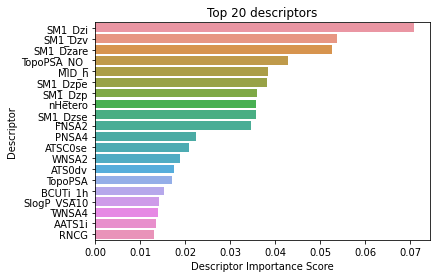

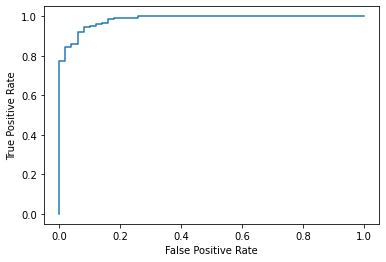

0.9834146341463414

In [54]:
test_model(tuned_rf, y_test_rf, X_test_rf)

## Extract correlation scores for important features

Extracted correlation scores for most important 100 features for random forest
Printing heatmap for most important 15 features


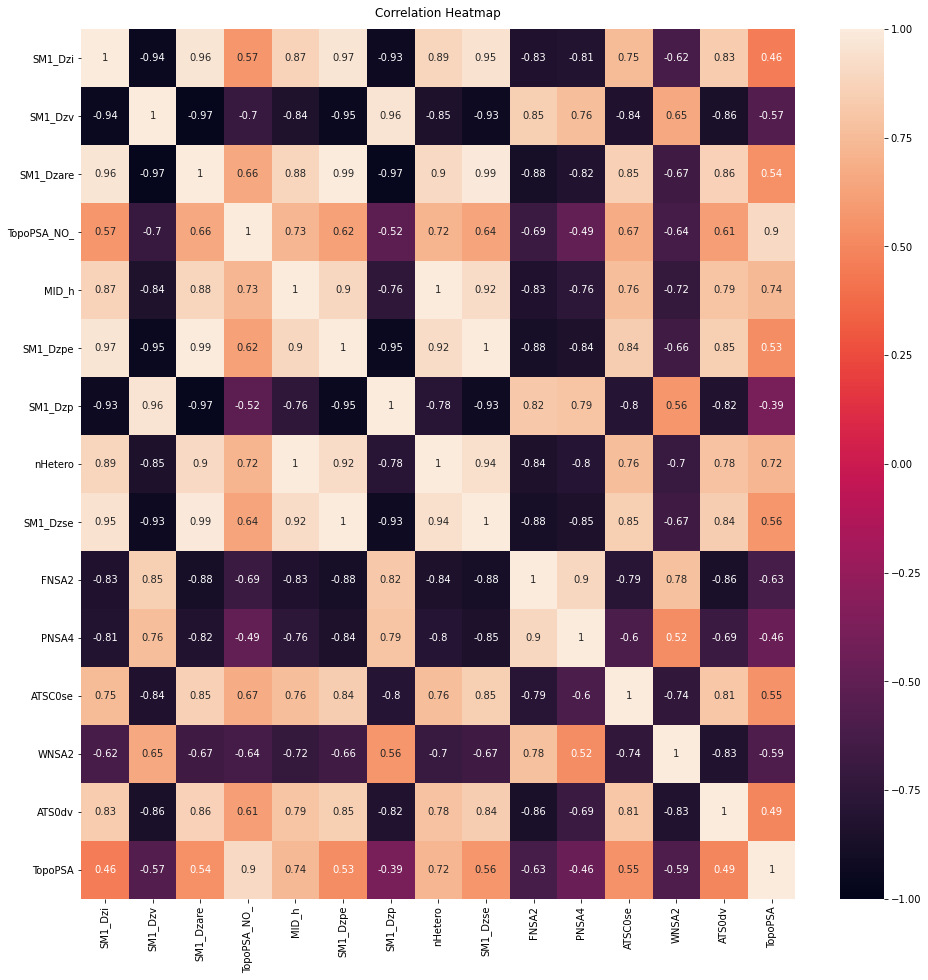

In [56]:
corrs_important_features(tuned_rf, X_test_rf, "random forest", 100, heatmap=15)

## Save dataframe used in RF to CSV
- i.e. dataframe with all columns with *any* missing values removed

In [57]:
rf_csv = df.loc[:,X_train_rf.columns]
rf_csv.to_csv('data/random-forest-df.csv')  
rf_csv

,FNSA2,TopoPSA_NO_,SM1_Dzse,SM1_Dzare,SM1_Dzi,ATSC0se,PNSA4,GRAV,WNSA4,SM1_Dzm,...,Mor09se,IC0,ATSC1dv,AATS0i,SMR,VSA_EState3,Mor31,Xpc_5dv,piPC2,AATSC1pe
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,-0.915439,74.60,0.993979,1.142857,0.692537,3.054191,-16.054904,2344.195126,-5.349824,0.997062,...,-0.413947,1.509028,5.393352,157.497908,42.2716,18.218704,0.191285,1.169741,3.597312,-0.037694
C(=C(F)F)(C(F)(F)F)C(F)(F)F,-1.298106,0.00,2.508000,3.121951,2.829626,4.193376,-31.248175,3079.984723,-9.026518,2.942312,...,-2.478051,0.918296,-4.000000,244.634092,21.3520,0.000000,0.254839,0.457475,3.135494,-0.082622
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],-1.567908,149.65,2.160253,2.557003,1.887688,3.687211,-29.743377,3420.554144,-10.720464,2.172360,...,-0.768105,1.896820,4.315789,170.915699,48.0700,40.214036,-0.326020,0.779968,3.725693,0.050768
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,-0.627113,32.67,0.738805,0.773658,0.755294,2.057077,-9.128078,3902.682223,-4.384569,1.195451,...,-0.683537,1.586645,37.083245,157.840303,81.8100,0.634380,0.556803,1.712699,4.025352,0.002859
C(C(C(F)(F)F)(F)Cl)(F)Cl,-1.026223,0.00,1.987068,2.184435,2.031838,3.734135,-26.660661,2814.087423,-7.618910,3.161314,...,-1.057832,1.789929,5.087440,219.944489,26.4960,-4.491512,0.235841,0.729616,2.772589,-0.053157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,-0.214952,26.30,0.496990,0.571429,0.346268,1.975926,-3.294040,1059.468170,-1.161034,0.498531,...,1.257362,1.264673,28.982987,167.274356,36.1580,0.000000,0.663010,0.100592,2.397895,0.004651
C=CCSS(=O)CC=C,-0.272162,17.07,0.391207,0.236534,-0.000667,1.148345,-5.106279,1564.446393,-1.820266,1.499983,...,0.145466,1.577977,-8.325023,158.423871,45.8614,0.000000,0.337999,0.530330,2.564949,0.001204
CCCC(=O)OCC(C)C,-0.222321,26.30,0.496990,0.571429,0.346268,2.012234,-3.194120,1218.316536,-1.193149,0.498531,...,1.344064,1.238901,30.994083,167.074610,40.7050,0.000000,0.830591,0.178519,2.564949,0.004367


# XgBoost

https://practicaldatascience.co.uk/machine-learning/how-to-create-a-classification-model-using-xgboost

In [58]:
# for readibility 
y_train_xgb = y_train
y_test_xgb = y_test
X_train_xgb = X_train
X_test_xgb = X_test

## Create model

In [59]:
xgb = XGBClassifier(random_state=SEED)
xgb.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

Baseline test performance of XGBoost
ROC_AUC (TEST): 0.9754471544715447


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.90      0.90      0.90        50
        True       0.96      0.96      0.96       123

    accuracy                           0.94       173
   macro avg       0.93      0.93      0.93       173
weighted avg       0.94      0.94      0.94       173



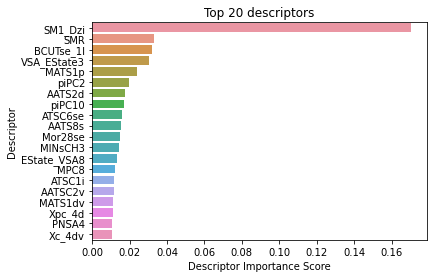

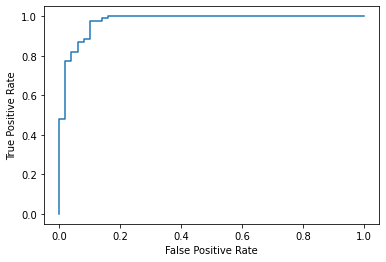

0.9754471544715447

In [60]:
# Baseline results
print("Baseline test performance of XGBoost")
test_model(xgb, y_test_xgb, X_test_xgb)

## Handle NaNs

Cross validated missing values experiment with k=5


,Name,Average ROC_AUC,Standard Deviation
0,0.0,0.970720,0.004632
1,0.1,0.969555,0.003055
2,0.2,0.969100,0.001470
3,0.3,0.968945,0.002606
4,0.4,0.966706,0.003670
5,0.5,0.966507,0.001691
6,0.6,0.968182,0.002727
7,0.7,0.967666,0.003408
8,0.8,0.968379,0.003460
9,0.9,0.968379,0.003460


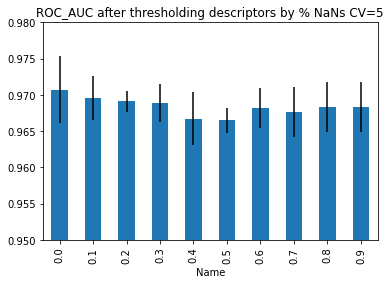

In [62]:
# choose optimal threshold for removing columns with NaNs
optimiseNaNs(xgb, X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb, option=2)

Choose to remove any columns with NaNs

In [65]:
X_train_xgb, X_test_xgb = handleNaNs(X_train_xgb.copy(), X_test_xgb.copy(), option=1)

Test performance of XGBoost after removing NaNs
ROC_AUC (TEST): 0.9705691056910569


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.94      0.90      0.92        50
        True       0.96      0.98      0.97       123

    accuracy                           0.95       173
   macro avg       0.95      0.94      0.94       173
weighted avg       0.95      0.95      0.95       173



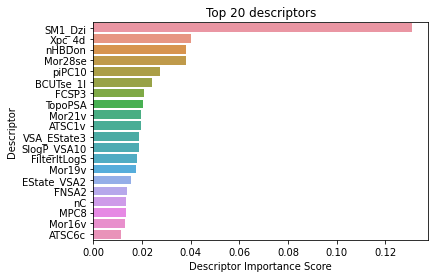

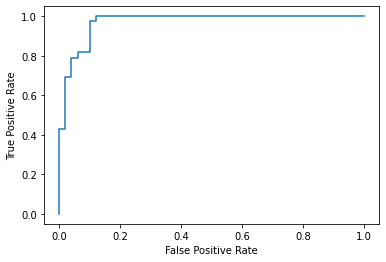

0.9705691056910569

In [66]:
xgb.fit(X_train_xgb, y_train_xgb)
print("Test performance of XGBoost after removing NaNs")
test_model(xgb, y_test_xgb, X_test_xgb)

## Importance Experiment XGB

Cross validated importance experiment with k=5
Threshold:0
Threshold:0.001
Threshold:0.01
N:100
N:500
N:1000
N:1203


,Name,Average ROC_AUC,Standard Deviation
0,Threshold:0,0.973315,0.003425
1,Threshold:0.001,0.977146,0.004565
2,Threshold:0.01,0.973111,0.004832
3,N:100,0.977904,0.004391
4,N:500,0.972460,0.003275
5,N:1000,0.971335,0.003883
6,N:1203,0.974384,0.003948


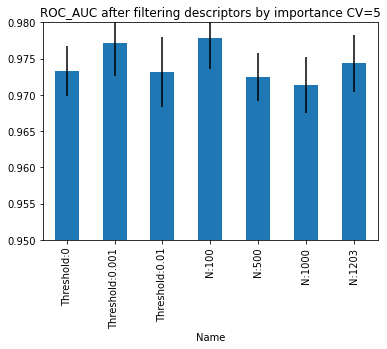

In [67]:
optimiseImportance(xgb, X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb)

Test performance after filtering by importance XGBoost
ROC_AUC (TEST): 0.9699186991869919


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.90      0.90      0.90        50
        True       0.96      0.96      0.96       123

    accuracy                           0.94       173
   macro avg       0.93      0.93      0.93       173
weighted avg       0.94      0.94      0.94       173



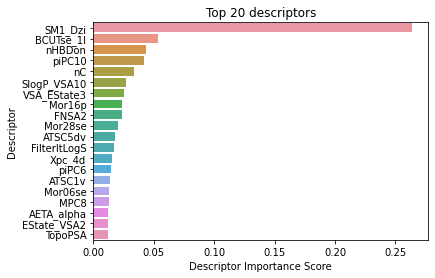

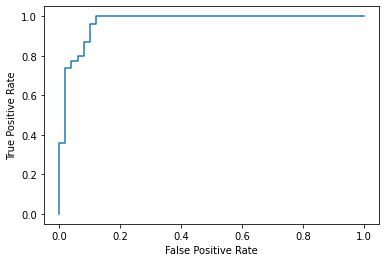

0.9699186991869919

In [68]:
X_train_xgb, X_test_xgb, xgb = handle_importance(xgb, 
                                                X_train_xgb, 
                                                X_test_xgb, 
                                                threshold=-1, 
                                                n=100)

xgb.fit(X_train_xgb, y_train_xgb)

# Filted importance results
print("Test performance after filtering by importance XGBoost")
test_model(xgb, y_test_xgb, X_test_xgb)

In [69]:
X_train_xgb

,SM1_Dzi,Xpc_4d,nHBDon,Mor28se,piPC10,BCUTse_1l,FCSP3,TopoPSA,Mor21v,ATSC1v,...,SIC3,PEOE_VSA9,Xc_3d,ATSC3c,Mor26,Mor13,Mor13p,IC0,MID_N,BCUTc_1l
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],0.917786,2.080880,1,0.172126,0.000000,2.437846,0.0,80.44,-0.195907,50.168861,...,1.000000,10.486763,1.000000,0.107048,-0.297601,-0.107249,-0.298644,1.777985,2.012880,-0.387593
CCCCCCCCCCCCCCCCO,0.173134,0.000000,1,-0.361095,2.079442,2.550132,1.0,20.23,-0.659213,-73.692870,...,0.467623,0.000000,0.000000,0.015420,1.057518,1.499624,0.576315,1.025881,0.000000,-0.223154
C1(C(O1)(F)F)(C(F)(F)F)F,2.295353,5.041815,0,-0.030493,0.000000,2.589681,1.0,12.53,-0.003930,-29.059914,...,0.796658,0.000000,2.774049,-0.076539,-0.065844,-0.592651,-0.292314,1.295462,0.000000,-0.293189
CC(C)(C=C)O,0.173134,1.060660,1,-0.154986,0.000000,2.498174,0.6,20.23,-0.063345,-64.083880,...,0.695160,5.601051,1.560660,-0.069567,0.294281,0.299103,-0.071999,1.198192,0.000000,-0.257264
C=CCC1=CC2=C(C=C1)OCO2,0.346268,1.327709,0,-0.118756,3.548180,2.437101,0.2,18.46,-0.120608,-32.245275,...,0.938843,0.000000,0.537457,0.083168,0.064225,-0.421997,-0.463456,1.348588,0.000000,-0.486864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCS,-0.086900,0.000000,1,-0.200455,0.000000,2.575514,1.0,38.80,-0.162785,-115.229220,...,0.816480,0.000000,0.000000,0.003194,0.278638,0.502512,0.217970,1.158939,0.000000,-0.173142
CCN(CC)CC,0.225250,0.612372,0,-0.212719,0.000000,2.608011,1.0,3.24,-0.318129,-213.508320,...,0.454182,0.000000,0.204124,-0.048836,0.298575,0.981494,0.275455,1.090653,2.045385,-0.374281
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,0.173134,1.541519,0,-0.082979,5.731874,2.432022,0.0,17.07,-0.330898,42.202219,...,0.713649,0.000000,0.525783,0.045485,-0.151671,0.443743,-0.291929,1.196421,0.000000,-0.377925


## Tuning paramaters 

In [98]:
params = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
#     'subsample': (0.7, 1.0),  # Change for big datasets
#     'colsample_bytree': (0.7, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5), 
    'scale_pos_weight': (1, 2.5)
    }

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        gamma, 
                        scale_pos_weight):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    xgb_temp = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma,
        scale_pos_weight=scale_pos_weight)
    
    # calculate CV=5 K fold ROC_AUC accuracy for each model 

    return np.array(cross_val_score(xgb_temp, X_train_xgb, y_train_xgb, cv=5, scoring='roc_auc')).mean()

optimizer = BayesianOptimization(
            f=xgboost_hyper_param,
            pbounds=params,
            random_state=SEED)

optimizer.maximize(init_points=2, n_iter=50)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | scale_... |
-------------------------------------------------------------------------------------
| 1         | 0.9745    | 2.744     | 0.718     | 7.219     | 590.4     | 1.635     |
| 2         | 0.9779    | 3.229     | 0.4432    | 9.242     | 967.3     | 1.575     |
| 3         | 0.9767    | 4.462     | 0.293     | 9.715     | 967.7     | 1.648     |
| 4         | 0.9763    | 1.768     | 0.5354    | 8.587     | 966.7     | 1.267     |
| 5         | 0.9751    | 2.545     | 0.7588    | 9.401     | 967.9     | 2.159     |
| 6         | 0.9764    | 3.699     | 0.1655    | 9.383     | 792.7     | 1.127     |
| 7         | 0.9818    | 3.16      | 0.3651    | 5.123     | 801.3     | 1.863     |
| 8         | 0.9757    | 4.369     | 0.3676    | 5.273     | 653.3     | 1.63      |
| 9         | 0.9682    | 3.383     | 0.8942    | 9.983     | 630.9     | 1.312     |
| 10        | 0.9771    | 1.443     | 0.8118    | 6.09

{'gamma': 3.1596294614733864, 'learning_rate': 0.3651332655950466, 'max_depth': 5, 'n_estimators': 801, 'scale_pos_weight': 1.8627159417510182}
ROC_AUC (TEST): 0.9744715447154472


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       1.00      0.88      0.94        50
        True       0.95      1.00      0.98       123

    accuracy                           0.97       173
   macro avg       0.98      0.94      0.96       173
weighted avg       0.97      0.97      0.96       173



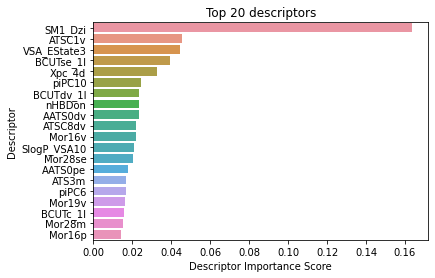

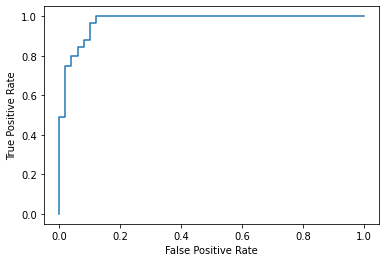

0.9744715447154472

In [100]:
params_tuned_xgb = optimizer.max['params']
params_tuned_xgb['max_depth'] = int(params_tuned_xgb['max_depth'])
params_tuned_xgb['n_estimators'] = int(params_tuned_xgb['n_estimators'])
print(params_tuned_xgb)

tuned_xgb = XGBClassifier(**params_tuned_xgb, seed=SEED)
tuned_xgb.fit(X_train_xgb, y_train_xgb)
test_model(tuned_xgb, y_test_xgb, X_test_xgb)

### Final tuned paramaters


ROC_AUC (TEST): 0.9744715447154472


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       1.00      0.88      0.94        50
        True       0.95      1.00      0.98       123

    accuracy                           0.97       173
   macro avg       0.98      0.94      0.96       173
weighted avg       0.97      0.97      0.96       173



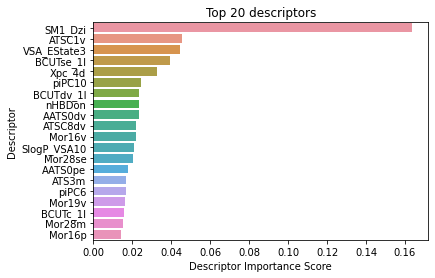

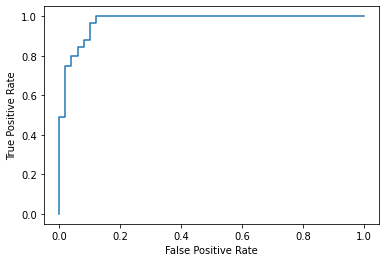

0.9744715447154472

In [102]:
tuned_xgb = XGBClassifier(gamma=3.1596294614733864, 
                          learning_rate=0.3651332655950466, 
                          max_depth=5, 
                          n_estimators=801, 
                          scale_pos_weight=1.8627159417510182,
                          seed=SEED,  
                          n_jobs = -1)
tuned_xgb.fit(X_train_xgb, y_train_xgb)
test_model(tuned_xgb, y_test_xgb, X_test_xgb)

## Extract correlation for 'important' features

Extracted correlation scores for most important 100 features for xgb
Printing heatmap for most important 15 features


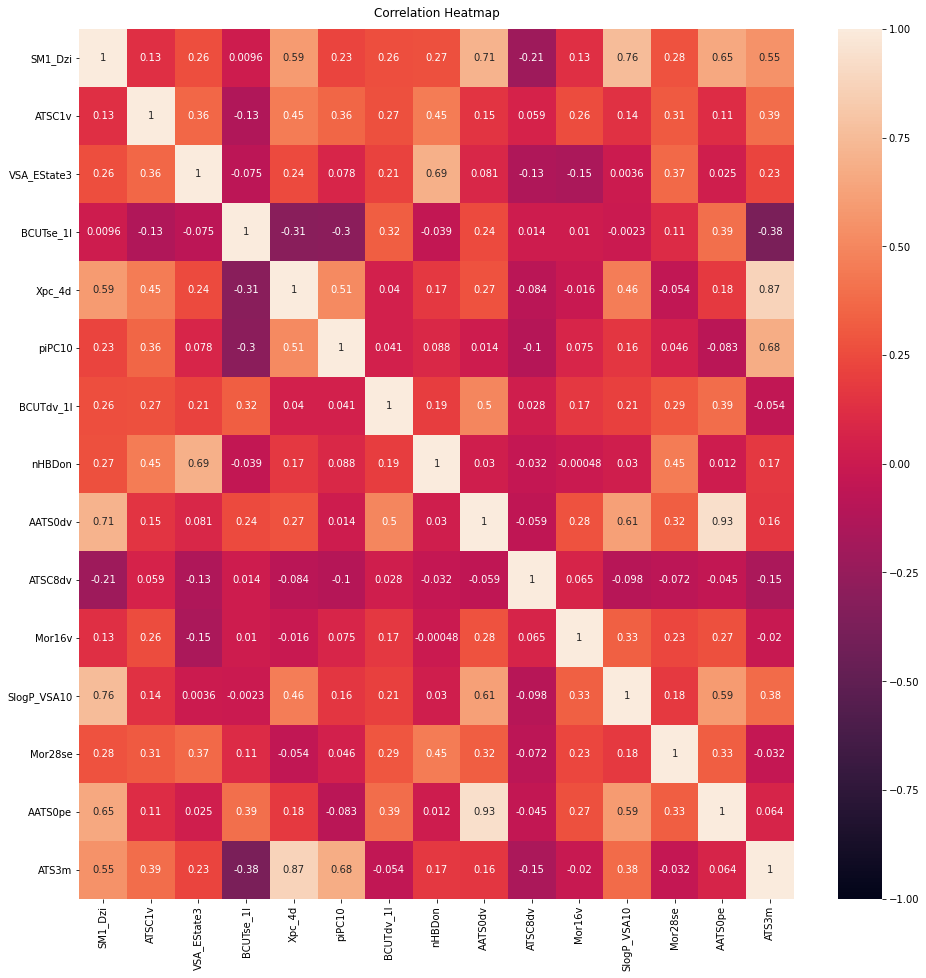

In [104]:
corrs_important_features(tuned_xgb, X_test_xgb, "xgb", 100, 15)

## Save dataframe used in XGB to CSV

In [105]:
rf_csv = df.loc[:,X_train_xgb.columns]
rf_csv.to_csv('data/xgb-df.csv')  
rf_csv

,SM1_Dzi,Xpc_4d,nHBDon,Mor28se,piPC10,BCUTse_1l,FCSP3,TopoPSA,Mor21v,ATSC1v,...,SIC3,PEOE_VSA9,Xc_3d,ATSC3c,Mor26,Mor13,Mor13p,IC0,MID_N,BCUTc_1l
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,0.692537,4.199803,2,0.409774,4.123094,2.433499,0.111111,74.60,-0.278505,141.691079,...,0.776981,0.000000,1.516182,0.232008,-0.241416,-0.985484,-0.636023,1.509028,0.000000,-0.369000
C(=C(F)F)(C(F)(F)F)C(F)(F)F,2.829626,2.866025,0,-0.115333,0.000000,2.492362,0.500000,0.00,0.119063,-23.514339,...,0.546490,0.000000,3.148717,-1.004040,0.040390,-0.549232,-0.331272,0.918296,0.000000,-0.231510
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],1.887688,3.478647,1,0.176266,0.000000,2.438368,0.000000,149.65,-0.253994,73.329816,...,0.857395,26.902667,1.631282,-0.118944,-0.511254,-0.088066,-0.329633,1.896820,6.048072,-0.387267
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,0.755294,3.312035,0,0.184432,7.092158,2.428710,0.125000,32.67,-0.518595,-14.411420,...,0.930858,11.399071,1.291742,0.148985,0.104435,0.195934,-0.534217,1.586645,4.191332,-0.399672
C(C(C(F)(F)F)(F)Cl)(F)Cl,2.031838,5.425426,0,-0.155282,0.000000,2.582453,1.000000,0.00,-0.023427,-18.751572,...,0.875048,0.000000,2.366025,-0.010165,0.106500,0.032360,0.084802,1.789929,0.000000,-0.251843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,0.346268,0.408248,0,-0.436179,0.000000,2.565122,0.857143,26.30,-0.315417,-149.595000,...,0.831705,6.606882,0.288675,-0.035943,0.324668,0.797557,0.248178,1.264673,0.000000,-0.496353
C=CCSS(=O)CC=C,-0.000667,0.408248,0,-0.369831,0.000000,2.510636,0.333333,61.58,-0.208334,21.460314,...,0.851321,15.584436,0.288675,0.003020,0.402102,0.063143,-0.087691,1.577977,0.000000,-0.360758
CCCC(=O)OCC(C)C,0.346268,0.696923,0,-0.479310,0.000000,2.560364,0.875000,26.30,-0.342441,-150.640033,...,0.768723,6.606882,0.696923,0.037507,0.480583,1.342821,0.383464,1.238901,0.000000,-0.495706


# Keras

https://www.pluralsight.com/guides/classification-keras

In [118]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 
from sklearn.metrics import roc_auc_score
from scikeras.wrappers import KerasClassifier

# for readibility 
y_train_nn = y_train
y_test_nn = y_test
X_train_nn = X_train
X_test_nn = X_test

Use adam optimizer so we don't have to specify learning rate, as is the case with gradient descent, and optimise for it

In [121]:
# one hot encode outputs
y_train_nn = to_categorical(y_train_nn)
y_test_nn = to_categorical(y_test_nn)

In [131]:
nn = Sequential()
nn.add(Dense(500, activation='relu', input_dim=len(X_train_nn.columns)))
nn.add(Dense(100, activation='relu'))
nn.add(Dense(50, activation='relu'))
nn.add(Dense(2, activation='softmax'))


# Compile the model

nn.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [132]:
# build the model
nn.fit(X_train_nn, y_train_nn, epochs=50, batch_size = 1)

Epoch 1/50
692/692 [==============================] - 7s 9ms/step - loss: nan - accuracy: 0.2890
Epoch 2/50
692/692 [==============================] - 5s 7ms/step - loss: nan - accuracy: 0.2890
Epoch 3/50
692/692 [==============================] - 5s 7ms/step - loss: nan - accuracy: 0.2890
Epoch 4/50
692/692 [==============================] - 5s 7ms/step - loss: nan - accuracy: 0.2890
Epoch 5/50
692/692 [==============================] - 5s 7ms/step - loss: nan - accuracy: 0.2890
Epoch 6/50
692/692 [==============================] - 5s 7ms/step - loss: nan - accuracy: 0.2890
Epoch 7/50
692/692 [==============================] - 5s 7ms/step - loss: nan - accuracy: 0.2890
Epoch 8/50
692/692 [==============================] - 5s 7ms/step - loss: nan - accuracy: 0.2890
Epoch 9/50
692/692 [==============================] - 5s 7ms/step - loss: nan - accuracy: 0.2890
Epoch 10/50
692/692 [==============================] - 5s 7ms/step - loss: nan - accuracy: 0.2890
Epoch 11/50
692/692 [========

In [133]:
pred_train= nn.predict(X_train_nn)

scores = nn.evaluate(X_train_nn, y_train_nn, verbose=0)

print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   

 

pred_test= nn.predict(X_test_nn)

scores2 = nn.evaluate(X_test_nn, y_test_nn, verbose=0)

print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

22/22 [==============================] - 0s 3ms/step
Accuracy on training data: 0.28901734948158264% 
 Error on training data: 0.7109826505184174
6/6 [==============================] - 0s 4ms/step
Accuracy on test data: 0.28901734948158264% 
 Error on test data: 0.7109826505184174
